In [68]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [69]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2000-01-01,0.783176
1,AAPL,2000-02-01,0.865268
2,AAPL,2000-03-01,1.025206
3,AAPL,2000-04-01,0.936509
4,AAPL,2000-05-01,0.634089
...,...,...,...
1974,NVDA,2024-03-01,90.344337
1975,NVDA,2024-04-01,86.394905
1976,NVDA,2024-05-01,109.624001
1977,NVDA,2024-06-01,123.529854


In [70]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [71]:
season_length = 12 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [72]:
# Generate forecasts for the specified horizon using the sf object
horizon = 3
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon)
Y_hat_df.head(5)

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-31,146.196518,144.227402,141.458511,136.714523
AAPL,2023-02-28,142.827316,145.345169,145.446655,142.094650
AAPL,2023-03-31,141.102432,146.462936,147.355835,141.603790
AMZN,2023-01-31,101.099319,103.128082,95.366661,98.909363
AMZN,2023-02-28,101.314880,103.128082,97.721832,100.288879


In [ ]:
Y_hat_df = Y_hat_df.reset_index()

In [83]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  16.144023  397.782369  0.096987  19.944482  10.471812

Model: AutoETS
         mae         mse      mape       rmse    smape:
0  14.174276  277.479886  0.085751  16.657728  9.108704

Model: AutoTheta
         mae         mse      mape       rmse    smape:
0  14.765778  269.559386  0.090092  16.418264  9.529942

Model: CES
        mae         mse      mape      rmse     smape:
0  19.38179  429.142305  0.119104  20.71575  12.759478

Results for MSFT:
Model: AutoARIMA
         mae         mse      mape       rmse     smape:
0  38.778051  2133.29007  0.132103  46.187553  14.546237

Model: AutoETS
         mae          mse      mape       rmse     smape:
0  31.978241  1550.835043  0.108185  39.380643  11.773216

Model: AutoTheta
         mae          mse      mape       rmse    smape:
0  38.740534  1939.999595  0.133302  44.045426  14.55167

Model: CES
         mae          mse      mape       rms

In [87]:
cv_df = sf.cross_validation(df=Y_train_df, h=3, n_windows=3, step_size=3, level=[99])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-05-01,2022-04-01,146.958969,150.877457,141.964264,159.790665,155.687454,109.518501,201.856400,155.687042,147.600754,163.937866,161.012573,146.997070,174.307846
AAPL,2022-06-01,2022-04-01,135.190491,164.219894,150.748001,177.691772,155.715591,90.200958,221.230225,151.822525,140.198822,164.594040,166.472092,152.871689,180.071014
AAPL,2022-07-01,2022-04-01,160.691986,173.247955,157.635590,188.860306,155.743729,75.229118,236.258347,156.833755,142.233551,171.694946,172.287552,157.801483,186.474808
AAPL,2022-08-01,2022-07-01,155.461151,166.664032,156.465622,176.862457,162.227402,114.687904,209.766891,166.932236,158.003723,176.042435,158.605545,143.733459,173.081696
AAPL,2022-09-01,2022-07-01,136.843750,162.446121,147.938477,176.953751,163.765259,95.433434,232.097076,156.477402,144.140503,170.031509,155.562134,141.448212,170.791458


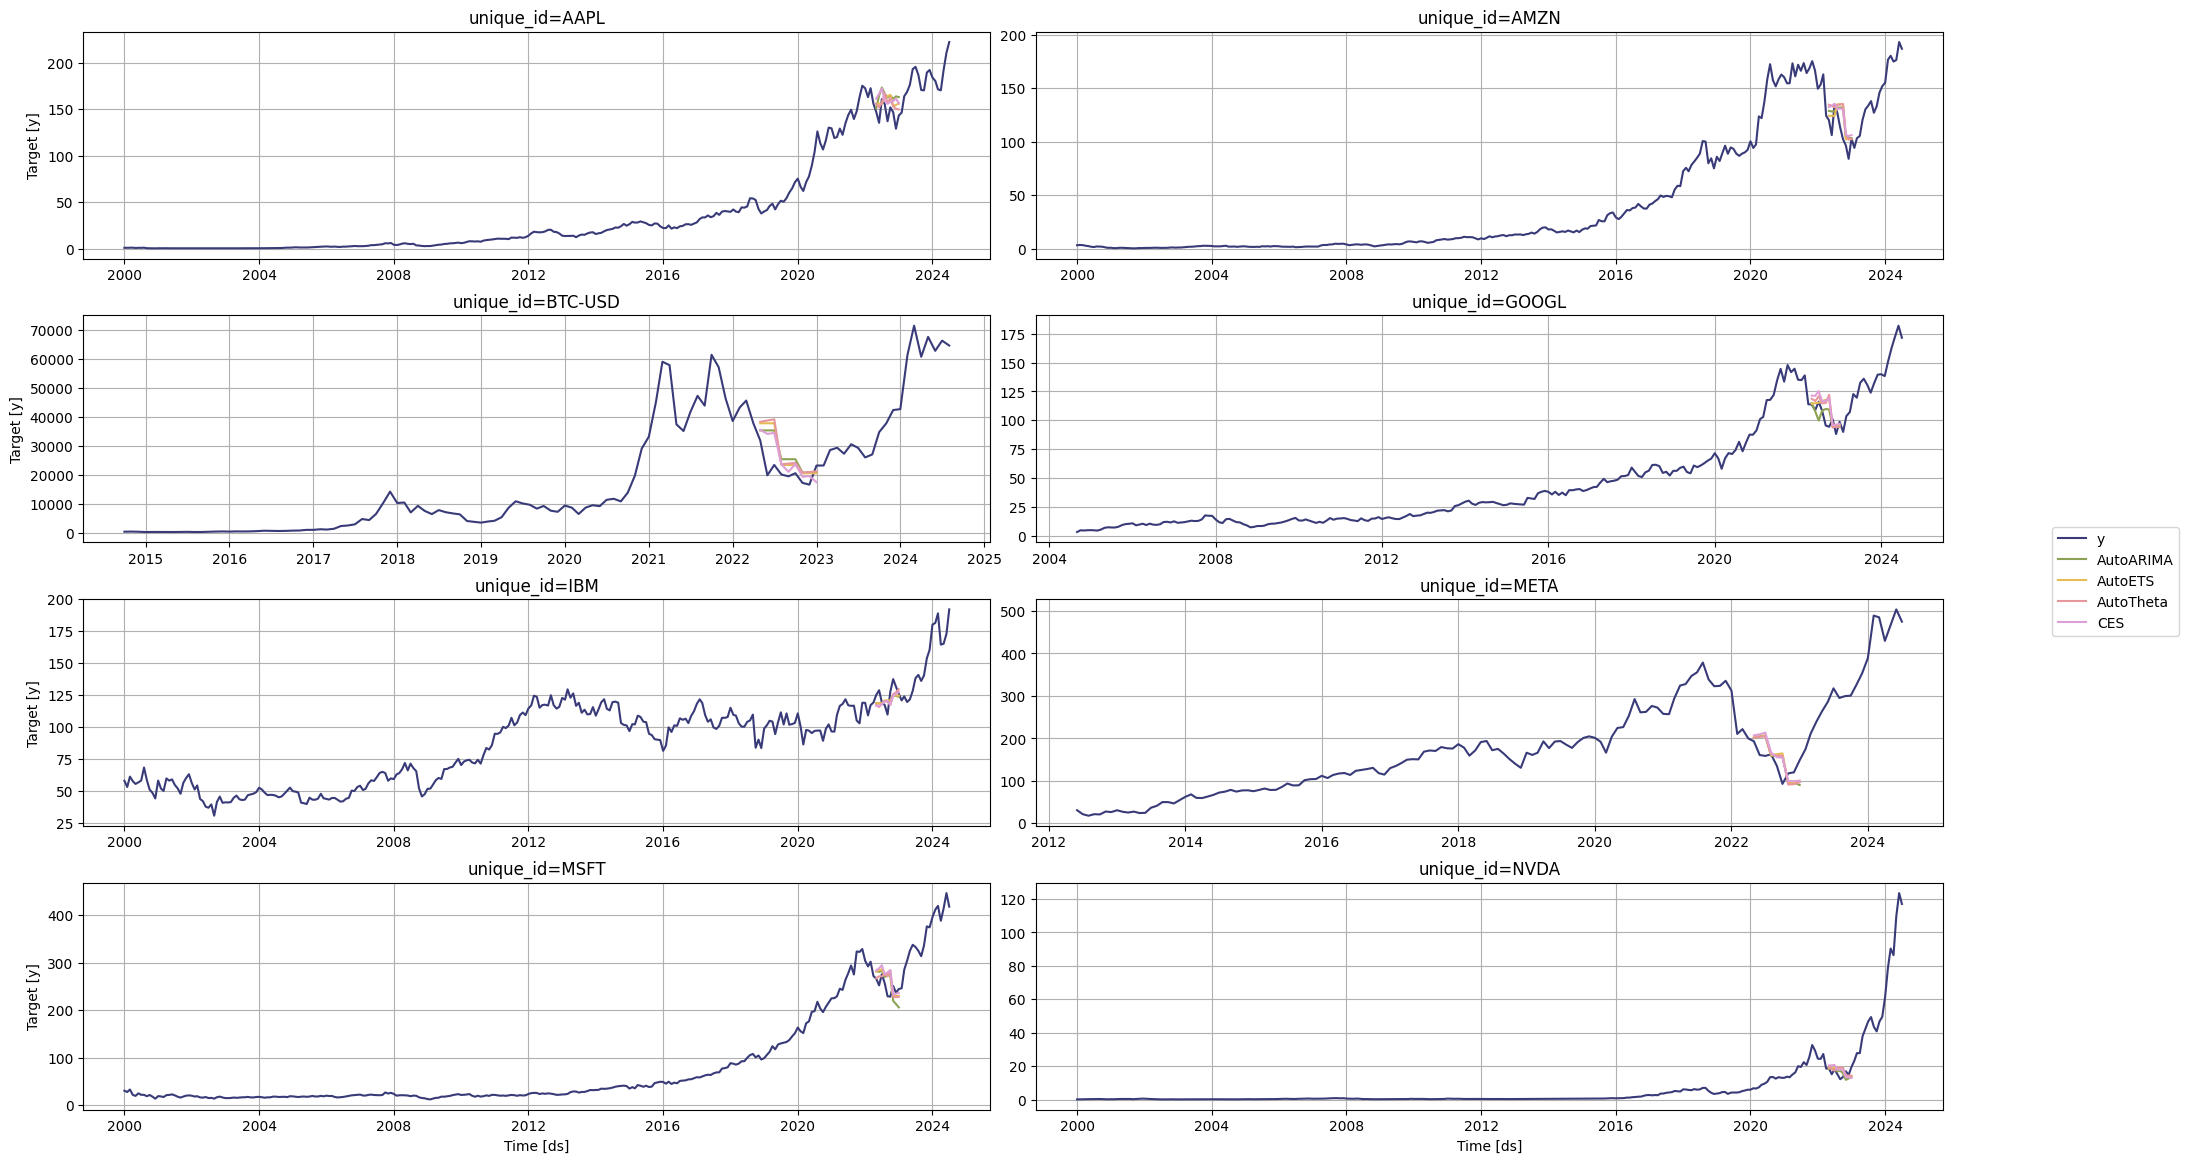

In [85]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))